# Draw Board -- Dynimic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import cv2

#plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [2]:
field_height, field_width = 180, 330
np.random.seed(60)
field         = np.ones([field_height, field_width, 3]).astype(np.uint8)
field[..., 1] = 255
rc            = 20

class Game:
    def __init__(self, n_player_per_team=3, field_height=field_height, field_width=field_width, seed=60, rc=rc):
        np.random.seed(seed)
                
        self.n_player_per_team = n_player_per_team
        self.ball   = Position(st=[200, 5], ed=[170, field_width])
        self.goal   = [field_height//2, field_width-5]
        self.rc     = rc
        
        self.court_offset  = 40
        self.court_right_x = field_width - self.court_offset
        self.court_left_x  = self.court_offset

        self.robots = []
        for i in range (n_player_per_team * 2):
            self.robots.append(Position())
        self.robots.append(self.ball)
        
        self.eps = 1e-10
        
        
    def get_DDB(self, N=59):
        sbd = []
        
        for idx in range(self.n_player_per_team * 2):
            sbd.append(  np.sqrt((self.robots[idx](N)[0] - self.ball(N)[0])**2 + (self.robots[idx](N)[1] - self.ball(N)[1])**2)   ) # y
        
        DDB = np.sum(sbd[:self.n_player_per_team]) - np.sum(sbd[self.n_player_per_team:])
        return DDB
    
    def get_bp(self, N=59):
        dist = np.abs(self.ball(N)[1] - self.goal[1])
        alfa = np.abs(self.ball(N)[0] - self.goal[0])
        return dist, alfa
    
    
    def get_param(self, N, dt=20):
        phi_t = self.get_phi(N, dt)
        c_t   = self.get_controll(N, dt)
        return phi_t, c_t
    
    def get_controll(self, N, dt=20):
        cm, co = 0, 0
        startT = max(N-dt, 0)
          
        for i in range(startT, N):
            cm += sum([self.is_controling(robot(i), self.ball(i)) for robot in self.robots[:self.n_player_per_team]])
            co += sum([self.is_controling(robot(i), self.ball(i)) for robot in self.robots[self.n_player_per_team:]])
        c_t = cm / (cm + co + self.eps); 
        
        return c_t
        
    def get_phi(self, N, dt=20):
        ## Warring: sum over time
        bm, bo = 0, 0
        startT = max(N-dt, 0)
          
        for i in range(startT, N):
            bm += self.ball_in_area(ball_pos=self.ball(i), use_right_goal=True)
            bo += self.ball_in_area(ball_pos=self.ball(i), use_right_goal=False)        
        phi_t = bm / (bm + bo + 1e-10); 
       
        return phi_t
    
    
    def is_controling(self, robot_pos, ball_pos):
        dist = np.sqrt((robot_pos[0]-ball_pos[0])**2 + (robot_pos[1]-ball_pos[1])**2)
        return dist <= rc

    def ball_in_area(self, ball_pos, use_right_goal=True):
        ball_x = ball_pos[1]

        if use_right_goal:
            return int(ball_x >= self.court_right_x)
        return int(ball_x <= self.court_left_x)

    

class Position:
    def __init__(self, N=60, st=[-1, -1], ed=[-1, -1], md=[-1, -1], md2=[-1, -1], 
                 field_height=field_height, field_width=field_width):
        
        if min(st) <= 0:
            st = [np.random.randint(0, field_height), np.random.randint(0, field_width)]
        if min(md) <= 0:
            md = [np.random.randint(0, field_height), np.random.randint(0, field_width)]
        if min(md2) <= 0:
            md2 = [np.random.randint(0, field_height), np.random.randint(0, field_width)]
        if min(ed) <= 0:
            ed = [np.random.randint(0, field_height), np.random.randint(0, field_width)]    
        
        self.st, self.md, self.md2 = np.array(st), np.array(md), np.array(md2)
        self.ed, self.N =  np.array(ed), N
        
        self.calculate_step1()
        self.calculate_step2()
        self.calculate_step3()
        
        
    def calculate_step1(self):
        self.step = (self.md - self.st) / (self.N/3)
        
        pos    = [self.st]
        actual = pos[0]
        for i in range(self.N//3):
            actual = actual + self.step
            pos.append(actual.astype(int))
        self.pos = pos
        
    def calculate_step2(self):
        self.step = (self.md2 - self.md) / (self.N/3)
        
        pos    = []
        actual = self.pos[-1]
        for i in range(self.N//3):
            actual = actual + self.step
            pos.append(actual.astype(int))
        self.pos = self.pos + pos
        
    def calculate_step3(self):
        self.step = (self.ed - self.md2) / (self.N/3)
        
        pos    = []
        actual = self.pos[-1]
        for i in range(self.N//3):
            actual = actual + self.step
            pos.append(actual.astype(int))
        self.pos = self.pos + pos
        
    def __call__(self, N=0):
        #N = N % self.N
        return self.pos[N]
    
    def cv_call(self, N=0):
        #N   = N % self.N
        pos = self.pos[N]
        
        return(pos[1], pos[0])
    
game = Game()

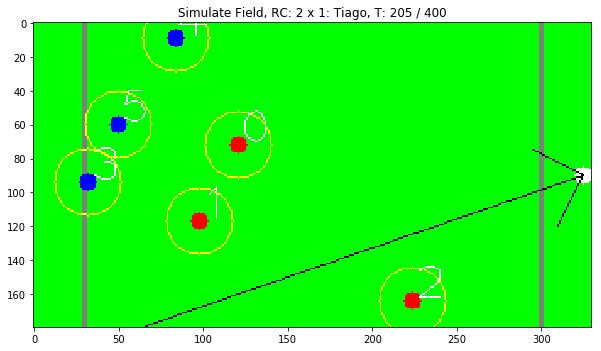

In [3]:
field_height, field_width = 180, 330
np.random.seed(60)
field = np.ones([field_height, field_width, 3]).astype(np.uint8)
field[..., 1] = 255
Rc     = 20

#ball = Position(st=[100, 5], ed=[80, field_width-5])

court_offset  = 30
court_right_x = field_width - court_offset
court_left_x  = court_offset
field = cv2.line(field.copy(), (court_left_x, 0), (court_left_x, field_height), (127,127,127), 2)
field = cv2.line(field.copy(), (court_right_x, 0), (court_right_x, field_height), (127,127,127), 2)

field  = cv2.circle(field.copy(), game.ball.cv_call(), 5, [255,127,0], -1)

for i in range(6):
    color = [255, 0, 0] if i <= 2 else [0, 0, 255]
    
    field = cv2.circle(field.copy(), game.robots[i].cv_call(), 5, color, -1)
    field = cv2.circle(field.copy(), game.robots[i].cv_call(), Rc, (255,255,0), 1)
    
    field = cv2.putText(field.copy(), str(i), game.robots[i].cv_call(), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))

goal = [field_height//2, field_width-5]
field = cv2.circle(field.copy(), (goal[1], goal[0]), 5, (255, 255, 255), -1)
field = cv2.arrowedLine(field.copy(), game.ball.cv_call(), (goal[1], goal[0]), 2)
    
TMAX = 400
t_now = np.random.randint(400)

score_op   = np.random.randint(5)
score_team = np.random.randint(5)


plt.figure(figsize=(10, 7));
plt.title(f"Simulate Field, RC: {score_team} x {score_op}: Tiago, T: {t_now} / {TMAX}")
plt.imshow(field)
plt.show()

In [4]:
def animate_loader(n):
    field = np.ones([field_height, field_width, 3]).astype(np.uint8)
    field[..., 1] = 255
    field = cv2.line(field.copy(), (court_left_x, 0), (court_left_x, field_height), (127,127,127), 2)
    field = cv2.line(field.copy(), (court_right_x, 0), (court_right_x, field_height), (127,127,127), 2)
    field = cv2.circle(field.copy(), game.ball.cv_call(n), 5, [255,127,0], -1)
    
    for i in range(6):
        color = [255, 0, 0] if i <= 2 else [0, 0, 255]

        field = cv2.circle(field.copy(), game.robots[i].cv_call(n), 5, color, -1)
        field = cv2.circle(field.copy(), game.robots[i].cv_call(n), Rc, (255, 255,0), 1)
        field = cv2.putText(field.copy(), str(i), game.robots[i].cv_call(n), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))

    goal = [field_height//2, field_width-5]
    field = cv2.circle(field.copy(), (goal[1], goal[0]), 5, (255, 255, 255), -1)
    field = cv2.arrowedLine(field.copy(), game.ball.cv_call(n), (goal[1], goal[0]), 2)
    
    extra_data = np.ones((50, field_width, 3), dtype=np.uint8) * 255
    
    DDB = game.get_DDB(n)
    bp_dist, bp_alfa = game.get_bp(n)
    phit, ct = game.get_param(n)
    
    extra_data = cv2.putText(extra_data.copy(), f't: {n:02d}| DDB: {int(DDB):03d}', (10, 15), 
                        cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,0))
    
    extra_text =  f'BDist: {int(bp_dist):03d} | Alfa: {int(bp_alfa):03d} | Phi: {int(np.round(phit)):01d} | Ct: {ct:0.2f}'
    extra_data = cv2.putText(extra_data.copy(),extra_text, (10, 35), 
                        cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,0))
    
    
    field = np.concatenate((field, extra_data), 0)
    
    return field

<Figure size 576x576 with 0 Axes>

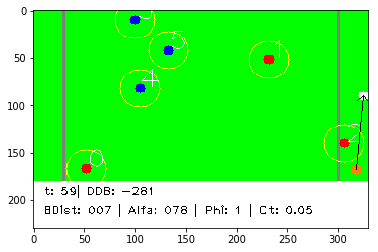

In [5]:
fps       = 20
nSeconds  = 3
snapshots = [ animate_loader(n) for n in range( 20*3 ) ]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a   = snapshots[0]
fig = plt.figure()

im = plt.imshow(a, interpolation='none', aspect='auto')

def animate_func(i):
    
    im.set_array(snapshots[i])
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = nSeconds * fps,
                               interval = 1000 / fps, blit=True )


#anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
HTML(anim.to_html5_video())